# Proyecto Final

***Equipo 07***

- Aide Jazmín González Cruz
- Elena Villalobos Nolasco
- Carolina Acosta Tovany

#### Instrucciones

El proyecto/examen final consistirá en:

La implementación del algoritmo de filtrado colaborativo utilizando la metodología vista en clase (uso de otra metodología no se calificará).

Todos los algoritmos de aprendizaje de máquina que se utilicen deberán haber sido creados por ustedes. Sólo podrán utilizar Transformers y funciones de apoyo de scikit-learn (para realizar la división de los datos en entrenamiento y prueba, o el procedimiento de validación cruzada, etc.) mas ningún estimator (regresión logística, máquina de vectores de soporte, k medias, etc.). 

Se deberá explicar como se obtuvo la k con la que se generó el resultado final.

Se utilizarán los archivos con el conjunto pequeño de calificaciones y películas ubicado en la siguiente https://www.kaggle.com/rounakbanik/the-movies-dataset:

- **links_small.csv**: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.

- **ratings_small.csv**: The subset of 100,000 ratings from 700 users on 9,000 movies.

Con el fin de mejorar la calificación (opcional, puntos extra), se podrán utilizar los algoritmos desarrollado en las tareas del curso y los datos relevantes (los que hacen match con los datos anteriores) contenidos en los archivos:

- **movies_metadata.csv**: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

- **keywords.csv**: Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

- **credits.csv**: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.

La métrica con la que se determinará el desempeño del algoritmo es el NDCG 

(https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG)

Una vez obtenida la matriz de calificaciones, el programa deberá ser capaz de regresar las 5 mejores recomendaciones del o de los usuarios que se consulten.

El proyecto se entregará en un Jupyter notebook. El readme file debe contener las instrucciones para que se ejecute el código. Deben cerciorarse que siguiendo esas instrucciones el programa corre sin errores. 

In [1]:
# Importación de paqueterías necesarias
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Importación de paqueterías creadas por nosotras
from sis_recom import load_data 
from sis_recom import create_train_test, fun_ECM
from sis_recom import recomendaciones_id
from sis_recom import desempenio_NDCG, obtain_ndcg_all_users

La función objetivo:
    
$$J(X) = \frac{1}{2} \displaystyle\sum_{(a,i)\in\mathbb{D}} \left(Y_{ai}-\left [ UV^T \right ]_{ai} \right)^2 + \frac{\lambda}{2} \displaystyle\sum_{a=1}^n \displaystyle\sum_{j=1}^k U_{aj}^2 + \frac{\lambda}{2} \displaystyle\sum_{i=1}^m \displaystyle\sum_{j=1}^k V_{ij}^2$$

Ya derivadas e igualadas a cero dependiendo de los usuarios e items:

$$x_u^T = r_uY\left(Y^TY+\lambda_xI\right)^{-1}$$

$$y_i^T = r_iX\left(X^TX+\lambda_yI\right)^{-1}$$

In [3]:
# Cargamos datos ya limpios
ratings, bases_nombres_id, arr_movies = load_data()

In [4]:
ratings.head()

,1,2,3,4,5,6,7,8,9,10,...,161830,161918,161944,162376,162542,162672,163056,163949,164977,164979
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
n_users, n_items = ratings.shape

In [6]:
n_users, n_items

(671, 9125)

In [7]:
# Separando datos en train y test
train, test = create_train_test(np.array(ratings))

In [8]:
train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [9]:
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
class Matrix_Factorization:
    """
    Factorización de matrices para predecir entradas vacías en una matriz
    
    Parametros
    ----------
    n_iters : numero de iteraciones para entregar algoritmo
        
    k : rank de la matriz
        
    _lambda : regularización
    """
    
    def __init__(self, n_iters, k, _lambda):
        self._lambda = _lambda
        self.n_iters = n_iters
        self.k = k  
        
    def fit(self, train, test):
        """
        partición de entrenamiento y test
        y selección de vectores aleatorios
        """
        self.n, self.m = train.shape
        
        self.Xu = np.random.random((self.n, self.k))
        self.Yi = np.random.random((self.m, self.k))
        
        self.test_ecm_record  = []
        self.train_ecm_record = []
        
        for _ in range(self.n_iters):
            self.Xu = self._als_step(train, self.Xu, self.Yi)
            self.Yi = self._als_step(train.T, self.Yi, self.Xu) 
            predictions = self.predict()
            test_ecm = self.compute_ecm(test, predictions)
            train_ecm = self.compute_ecm(train, predictions)
            self.train_ecm_record.append(train_ecm)
            self.test_ecm_record.append(test_ecm)
        
        return self    
    
    def _als_step(self, ratings, vec_res, vec_fij):
        """
        función que obtiene los vectores X_u ó Y_i
        """
        A = vec_fij.T.dot(vec_fij) + np.eye(self.k) * self._lambda
        b = ratings.dot(vec_fij)
        A_inv = np.linalg.inv(A)
        vec_res = b.dot(A_inv)
        return vec_res
    
    def predict(self):
        """Predicción de matriz completa XuYi (UV)"""
        pred = self.Xu.dot(self.Yi.T)
        return pred
    
    @staticmethod
    def compute_ecm(y_true, y_pred):
        mask = np.nonzero(y_true)
        ecm = fun_ECM(y_true[mask], y_pred[mask])

        return ecm
    
def best_K(train, test, K_list, n_iters=15, lambda_ = 0.01):
    df_k = pd.DataFrame(0.0, index=range(1), columns=K_list)    
    for k in K_list:
        als = Matrix_Factorization(n_iters, k, lambda_)
        als.fit(train, test)
        error = np.mean(als.test_ecm_record)
        df_k[k][0] = error

    return df_k

In [11]:
als = Matrix_Factorization(n_iters = 15, k = 36, _lambda = 0.01)
als.fit(train, test)

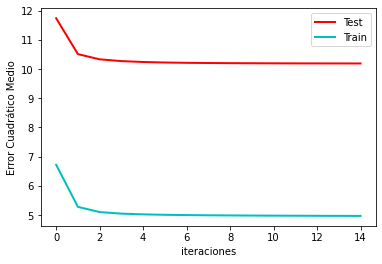

In [12]:
plt.plot(als.test_ecm_record, label = 'Test', linewidth = 2,color='r')
plt.plot(als.train_ecm_record, label = 'Train', linewidth = 2,color='c')
plt.xlabel('iteraciones')
plt.ylabel('Error Cuadrático Medio')
plt.legend(['Test','Train'])
plt.show()

Observamos que con muy pocas iteraciones el ECM baja, por lo que en las siguientes evaluaciones utilizaremos 15 iteraciones.

### Buscando la mejor K


In [13]:
np.random.seed(20201117)
K_list = [10,71,171,271,371,471,571,671]
df_k = best_K(train, test, K_list)
df_k

,10,71,171,271,371,471,571,671
0,10.725289,10.570593,11.781813,12.72651,13.365499,13.78757,14.04776,14.170276


In [14]:
K_list2 = [1,10,20,30,40,50,60]
df_k2 = best_K(train, test, K_list2)
df_k2

,1,10,20,30,40,50,60
0,12.277179,10.765336,10.470641,10.382057,10.337564,10.445505,10.476118


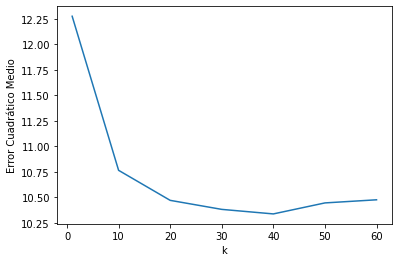

In [15]:
plt.plot(K_list2,df_k2.iloc[0])
plt.xlabel('k')
plt.ylabel('Error Cuadrático Medio')
plt.show()

In [16]:
K_list3 = [31,32,33,34,35,36,37,38,39]
df_k3 = best_K(train, test, K_list3)
df_k3

,31,32,33,34,35,36,37,38,39
0,10.368308,10.374968,10.363542,10.357243,10.351268,10.307344,10.392848,10.36641,10.349925


Con los resultados de hasta ahora vemos que **K = 36** tiene un mejor desempeño, el cuál varía dependiendo de los números random que se generan en la inicialización del vector U y V

## Validación

Una vez elegido el modelo realizaremos la validación: 

In [17]:
k_optima = 36

als = Matrix_Factorization(n_iters = 15, k = k_optima, _lambda = 0.01)
als.fit(train, test)

In [18]:
# Esta es la matriz completa para poder hacer recomendaciones
MCompleta = als.predict()
MCompleta = pd.DataFrame(MCompleta, 
                         columns=ratings.columns, 
                         index=ratings.index)

## Recomendaciones

**Ingrese un usuario nuevo aquí para mostrar las recomendaciones**

In [19]:
# Aquí puede cambiar el número de usuario para obtener sus recomendaciones
id_user = 2

In [20]:
rec_nvas, rec_todas = recomendaciones_id(np.array(ratings)[id_user-1], 
                                         np.array(MCompleta)[id_user-1], 
                                         arr_movies, 
                                         bases_nombres_id, 
                                         id_user)

In [21]:
# Listado de películas que no ha visto el usuario.
print("Estás son las nuevas películas que te recomendamos usuario no. ", id_user)
bases_nombres_id[bases_nombres_id['movieId'].isin(rec_nvas)][["movieId", "title"]]

Estás son las nuevas películas que te recomendamos usuario no.  2


,movieId,title
200,318,The Shawshank Redemption
1135,316,Stargate
1312,344,Ace Ventura: Pet Detective
2613,595,Beauty and the Beast
6655,380,True Lies


In [22]:
# Listado de películas que incluyen las que ya vio el usuario
print("Estás películas te pueden interesar usuario no. ", id_user)
bases_nombres_id[bases_nombres_id['movieId'].isin(rec_todas)][["movieId", "title"]]

Estás películas te pueden interesar usuario no.  2


,movieId,title
5,356,Forrest Gump
196,593,The Silence of the Lambs
288,527,Schindler's List
384,590,Dances with Wolves
477,296,Pulp Fiction


In [23]:
# Probemos el NDCG para este usuario
desempenio_NDCG(MCompleta.iloc[id_user])

0.51

#### Obtengamos  el desempeño para todos los usuarios

- Para la matriz obtenida

In [24]:
ndcg = obtain_ndcg_all_users(MCompleta)

- Para la matriz original

In [25]:
ndcg_Y_0 = obtain_ndcg_all_users(ratings)

Algunas comparaciones:

In [26]:
# Matriz final
for x in list(ndcg)[0:8]:
    print ("user: {} - ndcg: {}".format(x, ndcg[x]))

user: 1 - ndcg: 0.73
user: 2 - ndcg: 0.63
user: 3 - ndcg: 0.51
user: 4 - ndcg: 0.59
user: 5 - ndcg: 0.57
user: 6 - ndcg: 0.56
user: 7 - ndcg: 0.61
user: 8 - ndcg: 0.45


In [27]:
# Matriz inicial
for x in list(ndcg_Y_0)[0:8]:
    print ("user: {} - ndcg: {}".format(x, ndcg_Y_0[x]))

user: 1 - ndcg: 0.26
user: 2 - ndcg: 0.53
user: 3 - ndcg: 0.36
user: 4 - ndcg: 0.56
user: 5 - ndcg: 0.45
user: 6 - ndcg: 0.32
user: 7 - ndcg: 0.53
user: 8 - ndcg: 0.45


In [28]:
# Transformando diccionario a arreglo
# Datos predichos
ndcg_ar = list(ndcg.values())
# Datos originales
ndcg_Y_0_ar = list(ndcg_Y_0.values())
# Usuarios
list_fisrt_users = list(range(1, 51))

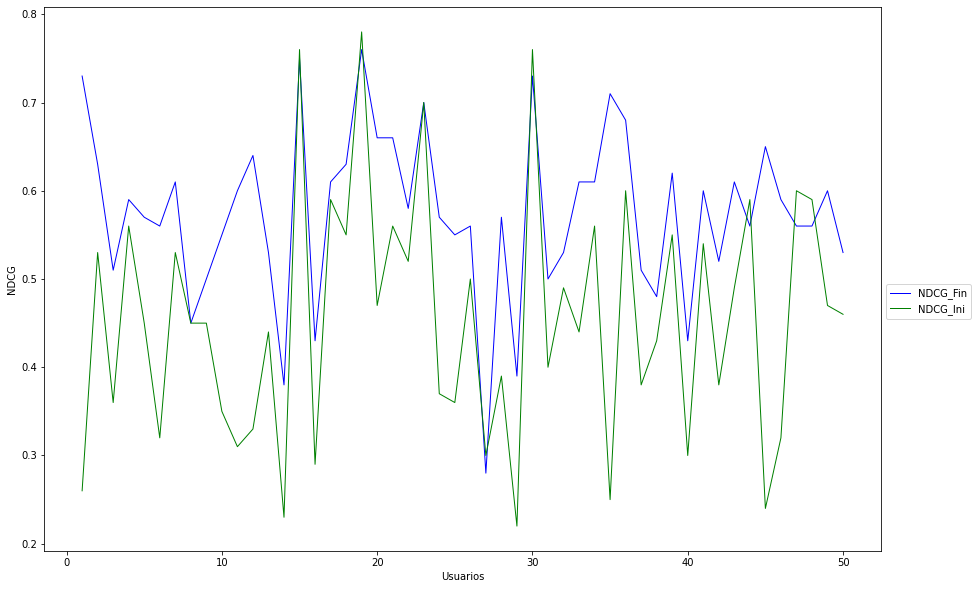

In [29]:
plt.figure(figsize=(15,10))
plt.plot(list_fisrt_users, ndcg_ar[:50], label = 'NDCG_Fin', linewidth = 1,color='b')
plt.plot(list_fisrt_users, ndcg_Y_0_ar[:50], label = 'NDCG_Ini', linewidth = 1,color='g')
plt.xlabel('Usuarios')
plt.ylabel('NDCG')
plt.legend(['NDCG_Fin','NDCG_Ini'],loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()

Se puede observar que se mejoró en el desempeño

In [30]:
#np.testing.assert_allclose(ndcg_ar[:,1], ndcg_Y_0_ar[:,1], atol=0.01, rtol=0.01)
np.testing.assert_allclose(ndcg_ar, ndcg_Y_0_ar, rtol=1e-5, atol=0)


AssertionError: 
Not equal to tolerance rtol=1e-05, atol=0

Mismatched elements: 647 / 671 (96.4%)
Max absolute difference: 0.51
Max relative difference: 2.
 x: array([0.73, 0.63, 0.51, 0.59, 0.57, 0.56, 0.61, 0.45, 0.5 , 0.55, 0.6 ,
       0.64, 0.53, 0.38, 0.75, 0.43, 0.61, 0.63, 0.76, 0.66, 0.66, 0.58,
       0.7 , 0.57, 0.55, 0.56, 0.28, 0.57, 0.39, 0.73, 0.5 , 0.53, 0.61,...
 y: array([0.26, 0.53, 0.36, 0.56, 0.45, 0.32, 0.53, 0.45, 0.45, 0.35, 0.31,
       0.33, 0.44, 0.23, 0.76, 0.29, 0.59, 0.55, 0.78, 0.47, 0.56, 0.52,
       0.7 , 0.37, 0.36, 0.5 , 0.3 , 0.39, 0.22, 0.76, 0.4 , 0.49, 0.44,...